THIS IS IDENTICAL TO 5, JUST WANTED TO RERUN THE WHOLE THING SO I CAN SHECK IF THE FEATURES I'M SEEING (HIGH COUNT BINS) ARE JUST STATISTICAL FLUCTUATION OR IF THEY SHOW AGAIN FOR A NEW RANDOMLY GENERATED SET

The goal of this notebook is to develop a simple model to measure the isotropy of a given configuration of points on a sphere. First, I would like to explain the measure that I am trying to test.

Consider a sphere with N points on it. Consider a fixed "opening angle" $\alpha$, pick a direction from the centre $\overrightarrow{u}$ (i.e. a point on the sphere, not necessarily one of the N) and count the number of points n out of the total N that lie inside the spherical cap of opening angle $\alpha$ centered on this direction.

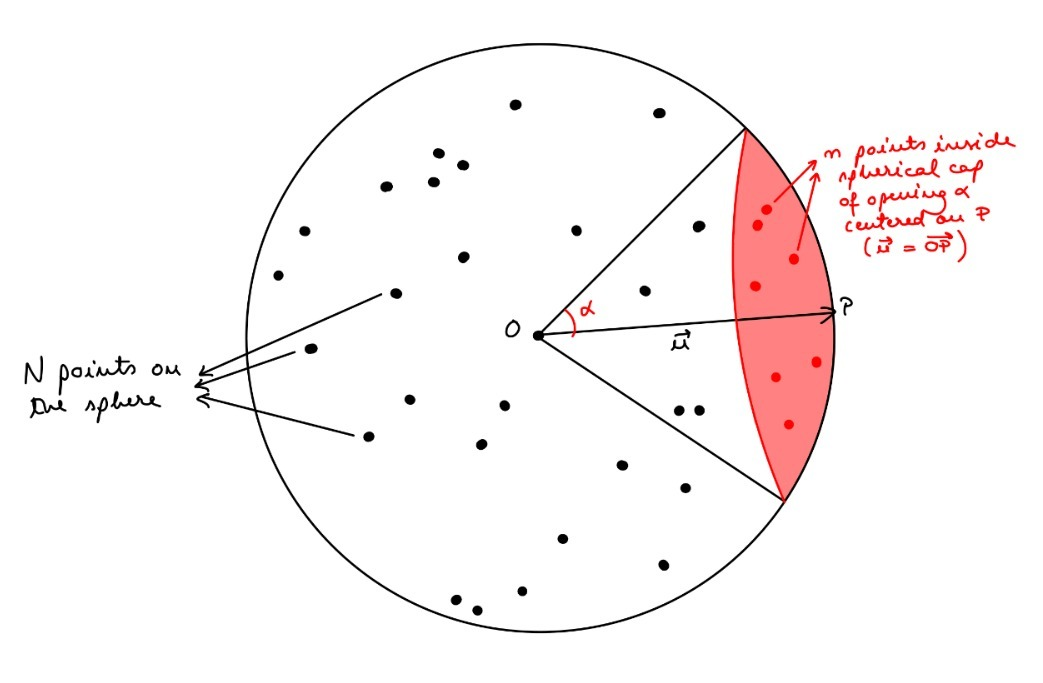



We will look at a large number of directions (these could be random or we could pick an isotropic arrangement of directions from the start, but I'll go with the second option for now) and plot the distribution of number of points in the spherical cap of opening $\alpha$ for each direction. For an isotropic distribution of the N points on the sphere, we expect this to be sharply peaked around $N \cdot \frac{A_{cap}}{A_{sphere}}$. 


As the distribution becomes less isotropic, expect the normalized variance of this distribution to increase. If this holds, define the isotropy measure $I_{\alpha} = \frac{\mathrm{Var}[n]}{\bar{n}}$, whee $\bar{n}$ is the mean of the distribution and $\mathrm{Var}[n]$ is the variance.

The overall plan for using this to define an isotropy criterion is the following:

1) Select a bunch of runs with various good PMT distributions
<br>

2) Simulate some electrons with fixed energy and look at the distribution of reconstructed energies. This should also be sharply peaked for good energy reconstruction, and we expect this to get worse as we have less and less active PMT's and as they are less and less isotropically distributed on the sphere (i.e. if we have big gaps)
<br>

3) Define what a "good" run is based on the width or variance of the distribution of reconstructed energies
<br>

4) Fix a value for $\alpha$
<br>

5) For each run, compute the mean n for the selected set of directions and the variance of the distribution
<br>

6) The set of "sufficiently isotropic" PMT configurations is defined by an upper limit on $\mathrm{Var}[n]$, $\mathrm{Var}[n]_{max}$
<br>

7) The set of "sufficiently dense" PMT configurations is defined by a lower limit on $\bar{n}$, $\bar{n}_{min}$
<br>

8) Find the values $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}$ and $\bar{n}_{min}$ that result in the greatest overlap between the "good" runs as defined by energy reconstruction, and the "good" runs defined by the parameters of the $n$ distribution

We could apply this procedure for different values of $\alpha$ and get different values for $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}(\alpha)$ and $\bar{n}_{min}(\alpha)$. We can set different criteria for different values of $\alpha$, but in order to keep this as computationally cheap as possible, we want to look for the value of $\alpha$ (and the associated $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}(\alpha)$ and $\bar{n}_{min}(\alpha)$) that maximises the overlap between the sets of good runs defined in the two different ways.

**Note**: I think finding the best value for $(\frac{\mathrm{Var}[n]}{\bar{n}})_{max}$ is enough for an isotropy criterion, but would be good to also have a density criterion; we might not need a separate coverage criterion if we do this

**Note**: When we pick the set of directions we're looking at, we might wish to avoid directions around the neck -- discuss in RS call

For now, we won't worry about definig good runs based on energy reconstruction, and we'll just look at some arrangements of points and their associated n-distribution. We will generate random points in Cartesian coordinates (in a 1x1x1 cube) then rescale them so that the modulus of the vectors is 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def generate_random_numbers(m, n, count):
    return np.random.uniform(m, n, count)

We will look at sets of $N = 10000$ points, so we're left with maybe around 5000 after removing cube corners.

In [3]:
def generate_points(N):
    x_array = generate_random_numbers(-1, 1, N)
    y_array = generate_random_numbers(-1, 1, N)
    z_array = generate_random_numbers(-1, 1, N)
    return x_array, y_array, z_array

In [4]:
x_array_1, y_array_1, z_array_1 = generate_points(10000)

In [5]:
points_set_1 = []


for i in range(10000):
    vector_length = (x_array_1[i]**2 + y_array_1[i]**2 + z_array_1[i]**2)**(1/2)
    
    if vector_length <= 1:
        points_set_1.append(np.array([x_array_1[i] / vector_length, y_array_1[i] / vector_length, z_array_1[i] / vector_length]))

points_set_1 = np.array(points_set_1)
print(points_set_1)        

print(len(points_set_1))

[[ 0.73066187  0.64509078 -0.22358694]
 [-0.1284483  -0.83299188  0.53816872]
 [ 0.9185778   0.33442479  0.21065347]
 ...
 [ 0.23061632 -0.34022547  0.91162643]
 [ 0.91145068 -0.28048509  0.3009747 ]
 [ 0.25709883 -0.31827952 -0.91246827]]
5196


In [6]:
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return r, phi, theta

def convert_points_to_spherical(points_set):
    points_set_polars = []
    for point in points_set:
        x, y, z = point
        r, phi, theta = cartesian_to_spherical(x, y, z)
        points_set_polars.append((r, phi, theta))
    return points_set_polars

In [7]:
points_set_polars_1 = convert_points_to_spherical(points_set_1)
#print(points_set_polars_1)

In [8]:
points_phi_1 = np.zeros(len(points_set_polars_1))
points_theta_1 = np.zeros(len(points_set_polars_1))

for i in range(len(points_set_polars_1)):
    points_phi_1[i] = points_set_polars_1[i][1]
    points_theta_1[i] = points_set_polars_1[i][2]

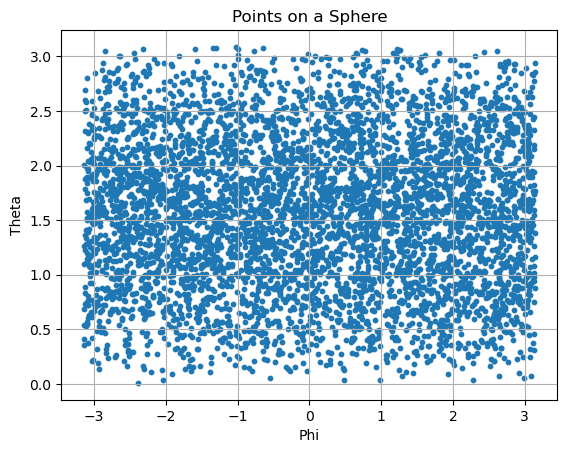

In [9]:
#Plot points on 2D map

plt.scatter(points_phi_1, points_theta_1, s = 10)

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('Points on a Sphere')
plt.grid(True)
plt.show()

These have been randomly generated and therefore they are quite isotropic. Will construct the desired distribution and we should see that it's quite isotropic. First, define the grid of directions (centres of caps)

Will start by looking at an opening angle of $\alpha = \pi/4$

The directions don't matter that much so keep them as they are

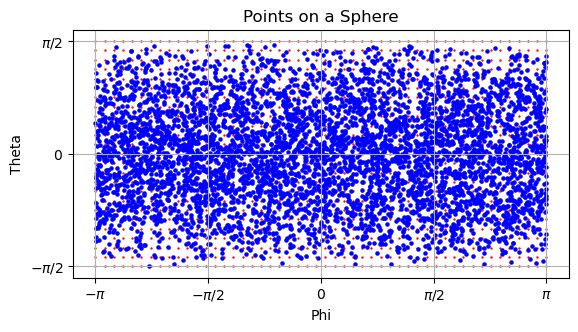

In [10]:
# Define grid sizes
grid_phi_size = 50
grid_theta_size = 25

# Define grid ranges
phi_min, phi_max = -np.pi, np.pi
theta_min, theta_max = 0, np.pi

# Create grid
grid_phi = np.linspace(phi_min, phi_max, grid_phi_size)
grid_theta = np.linspace(theta_min, theta_max, grid_theta_size)

# Create a meshgrid
phi_mesh, theta_mesh = np.meshgrid(grid_phi, grid_theta)

# Flatten the meshgrid and create points
points_phi_grid = phi_mesh.flatten()
points_theta_grid = theta_mesh.flatten()

# Plot the grid points
plt.scatter(points_phi_grid, points_theta_grid, s=0.5, color='red')  # Adjust marker size and color as needed
plt.scatter(points_phi_1, points_theta_1, s=5, color='blue')

# Set x-axis ticks
plt.xticks(np.linspace(phi_min, phi_max, 5), 
           ['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])

# Set y-axis ticks
plt.yticks(np.linspace(theta_min, theta_max, 3), 
           ['$-\pi/2$', '$0$', '$\pi/2$'])

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('Points on a Sphere')

# Set aspect ratio to 'equal'
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)
plt.show()


In [11]:
#make array of the grid_phi_size x grid_theta_size grid points in spherical coordinates

grid_points = np.ones((grid_phi_size*grid_theta_size, 3))

for i in range(len(grid_points)):
    grid_points[i][1] = points_phi_grid[i]
    grid_points[i][2] = points_theta_grid[i]

Here I'll add some explanation of the conversion, probably a screenshot from my ipad

Also, I don't think I needed to add the r coordinate but oh well, I included r = 1 in my conversion

In [12]:
def polars_cartesian_conversion(points_in_polars_array):
    #points_in_polars_array should be an array of size (X, 3); each element is (radius, phi, theta)
    #retursn an array of size (X, 3) each element being (x, y, z)
    
    points_in_cartesians_array = np.zeros(points_in_polars_array.shape)
    
    for i in range(len(points_in_polars_array)):
        # z = sin(theta)
        points_in_cartesians_array[i][2] = np.sin(points_in_polars_array[i][2])
        
        # |x| = cos(theta) / (1 + tan^2(phi))^(1/2)
        # x is positive if phi is in (pi/2, 3*pi/2) and negative otherwise
        
        if points_in_polars_array[i][1] > (np.pi/2) and points_in_polars_array[i][1] < (3*np.pi/2):
            points_in_cartesians_array[i][0] = - np.cos(points_in_polars_array[i][2]) / ((1 + (np.tan(points_in_polars_array[i][1]))**2)**(1/2))
        else:
            points_in_cartesians_array[i][0] = np.cos(points_in_polars_array[i][2]) / ((1 + (np.tan(points_in_polars_array[i][1]))**2)**(1/2))
            
        # y = x * tan(phi)
        
        points_in_cartesians_array[1] = points_in_cartesians_array[0] * np.tan(points_in_polars_array[i][1])
        
    return points_in_cartesians_array

In [13]:
#points_set_cartesians_1 = polars_cartesian_conversion(points_set_1)
grid_points_cartesians = polars_cartesian_conversion(grid_points)

In [14]:
#function that computes the angle between two vectors

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return angle_rad

In [15]:
print(len(points_set_1))

5196


In [16]:
points_in_cap_per_grid_point = np.zeros(len(grid_points_cartesians))

for i in range(len(grid_points_cartesians)): #for each directions
    
    counter = 0
    
    for j in range(len(points_set_1)): #for each of the N points
        angle = angle_between_vectors(grid_points_cartesians[i], points_set_1[j])
        if angle < np.pi/4:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(grid_points_cartesians)))
            
    points_in_cap_per_grid_point[i] = counter

computed for i = 0 out of 1250
computed for i = 1 out of 1250
computed for i = 2 out of 1250
computed for i = 3 out of 1250
computed for i = 4 out of 1250
computed for i = 5 out of 1250
computed for i = 6 out of 1250
computed for i = 7 out of 1250
computed for i = 8 out of 1250
computed for i = 9 out of 1250
computed for i = 10 out of 1250
computed for i = 11 out of 1250
computed for i = 12 out of 1250
computed for i = 13 out of 1250
computed for i = 14 out of 1250
computed for i = 15 out of 1250
computed for i = 16 out of 1250
computed for i = 17 out of 1250
computed for i = 18 out of 1250
computed for i = 19 out of 1250
computed for i = 20 out of 1250
computed for i = 21 out of 1250
computed for i = 22 out of 1250
computed for i = 23 out of 1250
computed for i = 24 out of 1250
computed for i = 25 out of 1250
computed for i = 26 out of 1250
computed for i = 27 out of 1250
computed for i = 28 out of 1250
computed for i = 29 out of 1250
computed for i = 30 out of 1250
computed for i = 3

computed for i = 252 out of 1250
computed for i = 253 out of 1250
computed for i = 254 out of 1250
computed for i = 255 out of 1250
computed for i = 256 out of 1250
computed for i = 257 out of 1250
computed for i = 258 out of 1250
computed for i = 259 out of 1250
computed for i = 260 out of 1250
computed for i = 261 out of 1250
computed for i = 262 out of 1250
computed for i = 263 out of 1250
computed for i = 264 out of 1250
computed for i = 265 out of 1250
computed for i = 266 out of 1250
computed for i = 267 out of 1250
computed for i = 268 out of 1250
computed for i = 269 out of 1250
computed for i = 270 out of 1250
computed for i = 271 out of 1250
computed for i = 272 out of 1250
computed for i = 273 out of 1250
computed for i = 274 out of 1250
computed for i = 275 out of 1250
computed for i = 276 out of 1250
computed for i = 277 out of 1250
computed for i = 278 out of 1250
computed for i = 279 out of 1250
computed for i = 280 out of 1250
computed for i = 281 out of 1250
computed f

computed for i = 501 out of 1250
computed for i = 502 out of 1250
computed for i = 503 out of 1250
computed for i = 504 out of 1250
computed for i = 505 out of 1250
computed for i = 506 out of 1250
computed for i = 507 out of 1250
computed for i = 508 out of 1250
computed for i = 509 out of 1250
computed for i = 510 out of 1250
computed for i = 511 out of 1250
computed for i = 512 out of 1250
computed for i = 513 out of 1250
computed for i = 514 out of 1250
computed for i = 515 out of 1250
computed for i = 516 out of 1250
computed for i = 517 out of 1250
computed for i = 518 out of 1250
computed for i = 519 out of 1250
computed for i = 520 out of 1250
computed for i = 521 out of 1250
computed for i = 522 out of 1250
computed for i = 523 out of 1250
computed for i = 524 out of 1250
computed for i = 525 out of 1250
computed for i = 526 out of 1250
computed for i = 527 out of 1250
computed for i = 528 out of 1250
computed for i = 529 out of 1250
computed for i = 530 out of 1250
computed f

computed for i = 750 out of 1250
computed for i = 751 out of 1250
computed for i = 752 out of 1250
computed for i = 753 out of 1250
computed for i = 754 out of 1250
computed for i = 755 out of 1250
computed for i = 756 out of 1250
computed for i = 757 out of 1250
computed for i = 758 out of 1250
computed for i = 759 out of 1250
computed for i = 760 out of 1250
computed for i = 761 out of 1250
computed for i = 762 out of 1250
computed for i = 763 out of 1250
computed for i = 764 out of 1250
computed for i = 765 out of 1250
computed for i = 766 out of 1250
computed for i = 767 out of 1250
computed for i = 768 out of 1250
computed for i = 769 out of 1250
computed for i = 770 out of 1250
computed for i = 771 out of 1250
computed for i = 772 out of 1250
computed for i = 773 out of 1250
computed for i = 774 out of 1250
computed for i = 775 out of 1250
computed for i = 776 out of 1250
computed for i = 777 out of 1250
computed for i = 778 out of 1250
computed for i = 779 out of 1250
computed f

computed for i = 1000 out of 1250
computed for i = 1001 out of 1250
computed for i = 1002 out of 1250
computed for i = 1003 out of 1250
computed for i = 1004 out of 1250
computed for i = 1005 out of 1250
computed for i = 1006 out of 1250
computed for i = 1007 out of 1250
computed for i = 1008 out of 1250
computed for i = 1009 out of 1250
computed for i = 1010 out of 1250
computed for i = 1011 out of 1250
computed for i = 1012 out of 1250
computed for i = 1013 out of 1250
computed for i = 1014 out of 1250
computed for i = 1015 out of 1250
computed for i = 1016 out of 1250
computed for i = 1017 out of 1250
computed for i = 1018 out of 1250
computed for i = 1019 out of 1250
computed for i = 1020 out of 1250
computed for i = 1021 out of 1250
computed for i = 1022 out of 1250
computed for i = 1023 out of 1250
computed for i = 1024 out of 1250
computed for i = 1025 out of 1250
computed for i = 1026 out of 1250
computed for i = 1027 out of 1250
computed for i = 1028 out of 1250
computed for i

computed for i = 1242 out of 1250
computed for i = 1243 out of 1250
computed for i = 1244 out of 1250
computed for i = 1245 out of 1250
computed for i = 1246 out of 1250
computed for i = 1247 out of 1250
computed for i = 1248 out of 1250
computed for i = 1249 out of 1250


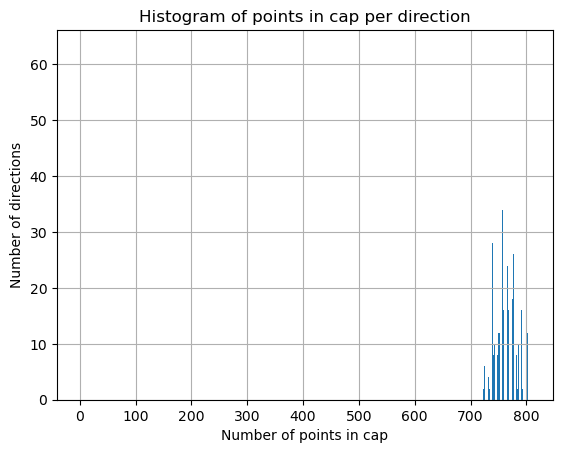

In [17]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)
plt.show()

This is terrible, something is clearly wrong. It's probably because of my coordinate conversion. I think instead of defining $\theta$ between $-\pi/2$ and $\pi/2$, it's best to stick to the usual range $[0, \pi)$ and use the standard conversion instead of trying to figure this out on my own

In version 2 of this notebook, I made the cap size larger and it fixed the issue, try here as well:

In [18]:
points_in_cap_per_grid_point = np.zeros(len(grid_points_cartesians))

for i in range(len(grid_points_cartesians)): #for each directions
    
    counter = 0
    
    for j in range(len(points_set_1)): #for each of the N points
        angle = angle_between_vectors(grid_points_cartesians[i], points_set_1[j])
        if angle < np.pi/3:
            counter += 1
            
    points_in_cap_per_grid_point[i] = counter
    print('computed for i = '+str(i)+' out of '+str(len(grid_points_cartesians)))

computed for i = 0 out of 1250
computed for i = 1 out of 1250
computed for i = 2 out of 1250
computed for i = 3 out of 1250
computed for i = 4 out of 1250
computed for i = 5 out of 1250
computed for i = 6 out of 1250
computed for i = 7 out of 1250
computed for i = 8 out of 1250
computed for i = 9 out of 1250
computed for i = 10 out of 1250
computed for i = 11 out of 1250
computed for i = 12 out of 1250
computed for i = 13 out of 1250
computed for i = 14 out of 1250
computed for i = 15 out of 1250
computed for i = 16 out of 1250
computed for i = 17 out of 1250
computed for i = 18 out of 1250
computed for i = 19 out of 1250
computed for i = 20 out of 1250
computed for i = 21 out of 1250
computed for i = 22 out of 1250
computed for i = 23 out of 1250
computed for i = 24 out of 1250
computed for i = 25 out of 1250
computed for i = 26 out of 1250
computed for i = 27 out of 1250
computed for i = 28 out of 1250
computed for i = 29 out of 1250
computed for i = 30 out of 1250
computed for i = 3

computed for i = 253 out of 1250
computed for i = 254 out of 1250
computed for i = 255 out of 1250
computed for i = 256 out of 1250
computed for i = 257 out of 1250
computed for i = 258 out of 1250
computed for i = 259 out of 1250
computed for i = 260 out of 1250
computed for i = 261 out of 1250
computed for i = 262 out of 1250
computed for i = 263 out of 1250
computed for i = 264 out of 1250
computed for i = 265 out of 1250
computed for i = 266 out of 1250
computed for i = 267 out of 1250
computed for i = 268 out of 1250
computed for i = 269 out of 1250
computed for i = 270 out of 1250
computed for i = 271 out of 1250
computed for i = 272 out of 1250
computed for i = 273 out of 1250
computed for i = 274 out of 1250
computed for i = 275 out of 1250
computed for i = 276 out of 1250
computed for i = 277 out of 1250
computed for i = 278 out of 1250
computed for i = 279 out of 1250
computed for i = 280 out of 1250
computed for i = 281 out of 1250
computed for i = 282 out of 1250
computed f

computed for i = 502 out of 1250
computed for i = 503 out of 1250
computed for i = 504 out of 1250
computed for i = 505 out of 1250
computed for i = 506 out of 1250
computed for i = 507 out of 1250
computed for i = 508 out of 1250
computed for i = 509 out of 1250
computed for i = 510 out of 1250
computed for i = 511 out of 1250
computed for i = 512 out of 1250
computed for i = 513 out of 1250
computed for i = 514 out of 1250
computed for i = 515 out of 1250
computed for i = 516 out of 1250
computed for i = 517 out of 1250
computed for i = 518 out of 1250
computed for i = 519 out of 1250
computed for i = 520 out of 1250
computed for i = 521 out of 1250
computed for i = 522 out of 1250
computed for i = 523 out of 1250
computed for i = 524 out of 1250
computed for i = 525 out of 1250
computed for i = 526 out of 1250
computed for i = 527 out of 1250
computed for i = 528 out of 1250
computed for i = 529 out of 1250
computed for i = 530 out of 1250
computed for i = 531 out of 1250
computed f

computed for i = 751 out of 1250
computed for i = 752 out of 1250
computed for i = 753 out of 1250
computed for i = 754 out of 1250
computed for i = 755 out of 1250
computed for i = 756 out of 1250
computed for i = 757 out of 1250
computed for i = 758 out of 1250
computed for i = 759 out of 1250
computed for i = 760 out of 1250
computed for i = 761 out of 1250
computed for i = 762 out of 1250
computed for i = 763 out of 1250
computed for i = 764 out of 1250
computed for i = 765 out of 1250
computed for i = 766 out of 1250
computed for i = 767 out of 1250
computed for i = 768 out of 1250
computed for i = 769 out of 1250
computed for i = 770 out of 1250
computed for i = 771 out of 1250
computed for i = 772 out of 1250
computed for i = 773 out of 1250
computed for i = 774 out of 1250
computed for i = 775 out of 1250
computed for i = 776 out of 1250
computed for i = 777 out of 1250
computed for i = 778 out of 1250
computed for i = 779 out of 1250
computed for i = 780 out of 1250
computed f

computed for i = 1000 out of 1250
computed for i = 1001 out of 1250
computed for i = 1002 out of 1250
computed for i = 1003 out of 1250
computed for i = 1004 out of 1250
computed for i = 1005 out of 1250
computed for i = 1006 out of 1250
computed for i = 1007 out of 1250
computed for i = 1008 out of 1250
computed for i = 1009 out of 1250
computed for i = 1010 out of 1250
computed for i = 1011 out of 1250
computed for i = 1012 out of 1250
computed for i = 1013 out of 1250
computed for i = 1014 out of 1250
computed for i = 1015 out of 1250
computed for i = 1016 out of 1250
computed for i = 1017 out of 1250
computed for i = 1018 out of 1250
computed for i = 1019 out of 1250
computed for i = 1020 out of 1250
computed for i = 1021 out of 1250
computed for i = 1022 out of 1250
computed for i = 1023 out of 1250
computed for i = 1024 out of 1250
computed for i = 1025 out of 1250
computed for i = 1026 out of 1250
computed for i = 1027 out of 1250
computed for i = 1028 out of 1250
computed for i

computed for i = 1241 out of 1250
computed for i = 1242 out of 1250
computed for i = 1243 out of 1250
computed for i = 1244 out of 1250
computed for i = 1245 out of 1250
computed for i = 1246 out of 1250
computed for i = 1247 out of 1250
computed for i = 1248 out of 1250
computed for i = 1249 out of 1250


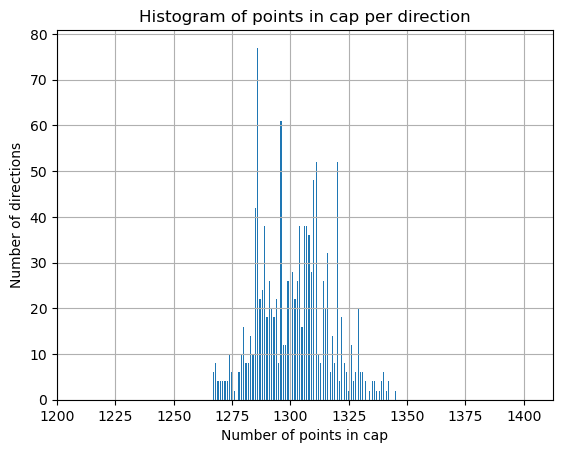

In [19]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

# Set limits for x and y axes
plt.xlim(1200, None)
#plt.ylim(None, 50)

plt.show()

Alright, we seem to be moving in the right direction!! We should probably also cut the corners of the cube where we are generating points because otherwise we'll be biased towards those directions, but it's a good start.

In [20]:
points_in_cap_per_grid_point = np.zeros(len(grid_points_cartesians))

for i in range(len(grid_points_cartesians)): #for each directions
    
    counter = 0
    
    for j in range(len(points_set_1)): #for each of the N points
        angle = angle_between_vectors(grid_points_cartesians[i], points_set_1[j])
        if angle < np.pi/6:
            counter += 1
            
    points_in_cap_per_grid_point[i] = counter
    print('computed for i = '+str(i)+' out of '+str(len(grid_points_cartesians)))

computed for i = 0 out of 1250
computed for i = 1 out of 1250
computed for i = 2 out of 1250
computed for i = 3 out of 1250
computed for i = 4 out of 1250
computed for i = 5 out of 1250
computed for i = 6 out of 1250
computed for i = 7 out of 1250
computed for i = 8 out of 1250
computed for i = 9 out of 1250
computed for i = 10 out of 1250
computed for i = 11 out of 1250
computed for i = 12 out of 1250
computed for i = 13 out of 1250
computed for i = 14 out of 1250
computed for i = 15 out of 1250
computed for i = 16 out of 1250
computed for i = 17 out of 1250
computed for i = 18 out of 1250
computed for i = 19 out of 1250
computed for i = 20 out of 1250
computed for i = 21 out of 1250
computed for i = 22 out of 1250
computed for i = 23 out of 1250
computed for i = 24 out of 1250
computed for i = 25 out of 1250
computed for i = 26 out of 1250
computed for i = 27 out of 1250
computed for i = 28 out of 1250
computed for i = 29 out of 1250
computed for i = 30 out of 1250
computed for i = 3

computed for i = 253 out of 1250
computed for i = 254 out of 1250
computed for i = 255 out of 1250
computed for i = 256 out of 1250
computed for i = 257 out of 1250
computed for i = 258 out of 1250
computed for i = 259 out of 1250
computed for i = 260 out of 1250
computed for i = 261 out of 1250
computed for i = 262 out of 1250
computed for i = 263 out of 1250
computed for i = 264 out of 1250
computed for i = 265 out of 1250
computed for i = 266 out of 1250
computed for i = 267 out of 1250
computed for i = 268 out of 1250
computed for i = 269 out of 1250
computed for i = 270 out of 1250
computed for i = 271 out of 1250
computed for i = 272 out of 1250
computed for i = 273 out of 1250
computed for i = 274 out of 1250
computed for i = 275 out of 1250
computed for i = 276 out of 1250
computed for i = 277 out of 1250
computed for i = 278 out of 1250
computed for i = 279 out of 1250
computed for i = 280 out of 1250
computed for i = 281 out of 1250
computed for i = 282 out of 1250
computed f

computed for i = 502 out of 1250
computed for i = 503 out of 1250
computed for i = 504 out of 1250
computed for i = 505 out of 1250
computed for i = 506 out of 1250
computed for i = 507 out of 1250
computed for i = 508 out of 1250
computed for i = 509 out of 1250
computed for i = 510 out of 1250
computed for i = 511 out of 1250
computed for i = 512 out of 1250
computed for i = 513 out of 1250
computed for i = 514 out of 1250
computed for i = 515 out of 1250
computed for i = 516 out of 1250
computed for i = 517 out of 1250
computed for i = 518 out of 1250
computed for i = 519 out of 1250
computed for i = 520 out of 1250
computed for i = 521 out of 1250
computed for i = 522 out of 1250
computed for i = 523 out of 1250
computed for i = 524 out of 1250
computed for i = 525 out of 1250
computed for i = 526 out of 1250
computed for i = 527 out of 1250
computed for i = 528 out of 1250
computed for i = 529 out of 1250
computed for i = 530 out of 1250
computed for i = 531 out of 1250
computed f

computed for i = 751 out of 1250
computed for i = 752 out of 1250
computed for i = 753 out of 1250
computed for i = 754 out of 1250
computed for i = 755 out of 1250
computed for i = 756 out of 1250
computed for i = 757 out of 1250
computed for i = 758 out of 1250
computed for i = 759 out of 1250
computed for i = 760 out of 1250
computed for i = 761 out of 1250
computed for i = 762 out of 1250
computed for i = 763 out of 1250
computed for i = 764 out of 1250
computed for i = 765 out of 1250
computed for i = 766 out of 1250
computed for i = 767 out of 1250
computed for i = 768 out of 1250
computed for i = 769 out of 1250
computed for i = 770 out of 1250
computed for i = 771 out of 1250
computed for i = 772 out of 1250
computed for i = 773 out of 1250
computed for i = 774 out of 1250
computed for i = 775 out of 1250
computed for i = 776 out of 1250
computed for i = 777 out of 1250
computed for i = 778 out of 1250
computed for i = 779 out of 1250
computed for i = 780 out of 1250
computed f

computed for i = 1001 out of 1250
computed for i = 1002 out of 1250
computed for i = 1003 out of 1250
computed for i = 1004 out of 1250
computed for i = 1005 out of 1250
computed for i = 1006 out of 1250
computed for i = 1007 out of 1250
computed for i = 1008 out of 1250
computed for i = 1009 out of 1250
computed for i = 1010 out of 1250
computed for i = 1011 out of 1250
computed for i = 1012 out of 1250
computed for i = 1013 out of 1250
computed for i = 1014 out of 1250
computed for i = 1015 out of 1250
computed for i = 1016 out of 1250
computed for i = 1017 out of 1250
computed for i = 1018 out of 1250
computed for i = 1019 out of 1250
computed for i = 1020 out of 1250
computed for i = 1021 out of 1250
computed for i = 1022 out of 1250
computed for i = 1023 out of 1250
computed for i = 1024 out of 1250
computed for i = 1025 out of 1250
computed for i = 1026 out of 1250
computed for i = 1027 out of 1250
computed for i = 1028 out of 1250
computed for i = 1029 out of 1250
computed for i

computed for i = 1242 out of 1250
computed for i = 1243 out of 1250
computed for i = 1244 out of 1250
computed for i = 1245 out of 1250
computed for i = 1246 out of 1250
computed for i = 1247 out of 1250
computed for i = 1248 out of 1250
computed for i = 1249 out of 1250


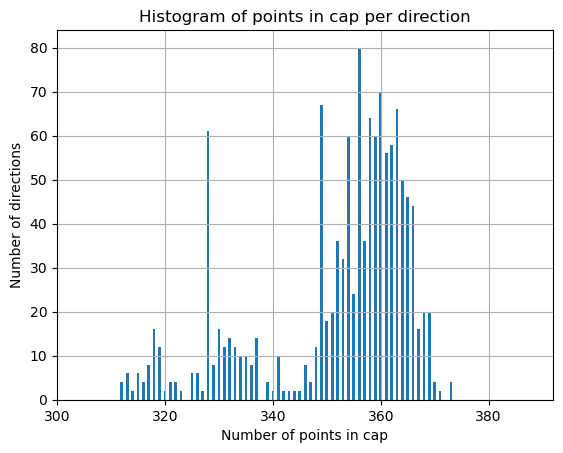

In [21]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.xlim(300, None)

plt.show()

They all look quite reasonable now; Try again with many more points in notebook 5 -THIS IS NOTEBOOK 5, AND I DID JUST THAT!